##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [4]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, 
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Bangla Article Classification With TF-Hub

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/bangla_article_classifier"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Caution: In addition to installing Python packages with pip, this notebook uses
`sudo apt install` to install system packages: `unzip`.

This Colab is a demonstration of using [Tensorflow Hub](https://www.tensorflow.org/hub/) for text classification in non-English/local languages. Here we choose [Bangla](https://en.wikipedia.org/wiki/Bengali_language) as the local language and use pretrained word embeddings to solve a multiclass classification task where we classify Bangla news articles in 5 categories.  The pretrained embeddings for Bangla comes from [fastText](https://fasttext.cc/docs/en/crawl-vectors.html) which is a library by Facebook with released pretrained word vectors for 157 languages. 

We'll use TF-Hub's pretrained embedding exporter for converting the word embeddings to a text embedding module first and then use the module to train a classifier with [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras), Tensorflow's high level user friendly API to build deep learning models.  Even if we are using fastText embeddings here, it's possible to export any other embeddings pretrained from other tasks and quickly get results with Tensorflow hub. 

## Setup

In [5]:
%%bash
# https://github.com/pypa/setuptools/issues/1694#issuecomment-466010982
pip install gdown --no-use-pep517

In [6]:
%%bash
# sudo apt-get install -y unzip

In [7]:
import os

import tensorflow as tf
import tensorflow_hub as hub

import gdown
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

2023-02-21 16:32:49.906328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset

We will use [BARD](https://www.researchgate.net/publication/328214545_BARD_Bangla_Article_Classification_Using_a_New_Comprehensive_Dataset) (Bangla Article Dataset) which has around 376,226 articles collected from different Bangla news portals and labelled with 5 categories: economy, state, international, sports, and entertainment. We download the file from Google Drive this ([bit.ly/BARD_DATASET](bit.ly/BARD_DATASET)) link is referring to from [this](https://github.com/tanvirfahim15/BARD-Bangla-Article-Classifier) GitHub repository.


In [8]:
gdown.download(
    url='https://drive.google.com/uc?id=1Ag0jd21oRwJhVFIBohmX_ogeojVtapLy',
    output='bard.zip',
    quiet=True
)

'bard.zip'

In [9]:
%%bash
unzip -qo bard.zip

# Export pretrained word vectors to TF-Hub module

TF-Hub provides some useful scripts for converting word embeddings to TF-hub text embedding modules [here](https://github.com/tensorflow/hub/tree/master/examples/text_embeddings_v2). To make the module for Bangla or any other languages, we simply have to download the word embedding `.txt` or `.vec` file to the same directory as `export_v2.py` and run the script.


The exporter reads the embedding vectors and exports it to a Tensorflow [SavedModel](https://www.tensorflow.org/beta/guide/saved_model). A SavedModel contains a complete TensorFlow program including weights and graph. TF-Hub can load the SavedModel as a [module](https://www.tensorflow.org/hub/api_docs/python/hub/Module), which we will use to build the model for text classification. Since we are using `tf.keras` to build the model, we will use [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer), which provides a wrapper for a TF-Hub module to use as a Keras Layer.

First we will get our word embeddings from fastText and embedding exporter from TF-Hub [repo](https://github.com/tensorflow/hub).


In [10]:
%%bash
curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
curl -O https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py
gunzip -qf cc.bn.300.vec.gz --k

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  840M  100  840M    0     0  9700k      0  0:01:28  0:01:28 --:--:-- 10.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7500  100  7500    0     0  58019      0 --:--:-- --:--:-- --:--:-- 60483


Then, we will run the exporter script on our embedding file. Since fastText embeddings have a header line and are pretty large (around 3.3 GB for Bangla after converting to a module) we ignore the first line and export only the first 100, 000 tokens to the text embedding module.

In [11]:
%%bash
python3 export_v2.py --embedding_file=cc.bn.300.vec --export_path=text_module --num_lines_to_ignore=1 --num_lines_to_use=100000

2023-02-21 16:39:03.179353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 16:39:17.624412: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:tensorflow:Assets written to: text_module/assets
I0221 16:39:19.083049 140704728929920 builder_impl.py:797] Assets written to: text_module/assets


In [12]:
module_path = "text_module"
embedding_layer = hub.KerasLayer(module_path, trainable=False)

2023-02-21 16:39:19.911037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The text embedding module takes a batch of sentences in a 1D tensor of strings as input and outputs the embedding vectors of shape (batch_size, embedding_dim) corresponding to the sentences. It preprocesses the input by splitting on spaces. Word embeddings are combined to sentence embeddings with the `sqrtn` combiner(See [here](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup_sparse)). For demonstration we pass a list of Bangla words as input and get the corresponding embedding vectors.

In [13]:
embedding_layer(['বাস', 'বসবাস', 'ট্রেন', 'যাত্রী', 'ট্রাক']) 

<tf.Tensor: shape=(5, 300), dtype=float64, numpy=
array([[ 0.0462, -0.0355,  0.0129, ...,  0.0025, -0.0966,  0.0216],
       [-0.0631, -0.0051,  0.085 , ...,  0.0249, -0.0149,  0.0203],
       [ 0.1371, -0.069 , -0.1176, ...,  0.029 ,  0.0508, -0.026 ],
       [ 0.0532, -0.0465, -0.0504, ...,  0.02  , -0.0023,  0.0011],
       [ 0.0908, -0.0404, -0.0536, ..., -0.0275,  0.0528,  0.0253]])>

# Convert to Tensorflow Dataset 


Since the dataset is really large instead of loading the entire dataset in memory we will use a generator to yield samples in run-time in batches using [Tensorflow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) functions. The dataset is also very imbalanced, so, before using the generator, we will shuffle the dataset. 


In [14]:
dir_names = ['economy', 'sports', 'entertainment', 'state', 'international']

file_paths = []
labels = []
for i, dir in enumerate(dir_names):
  file_names = ["/".join([dir, name]) for name in os.listdir(dir)]
  file_paths += file_names
  labels += [i] * len(os.listdir(dir))
  
np.random.seed(42)
permutation = np.random.permutation(len(file_paths))

file_paths = np.array(file_paths)[permutation]
labels = np.array(labels)[permutation]

We can check the distribution of labels in the training and validation examples after shuffling.

In [15]:
train_frac = 0.8
train_size = int(len(file_paths) * train_frac)

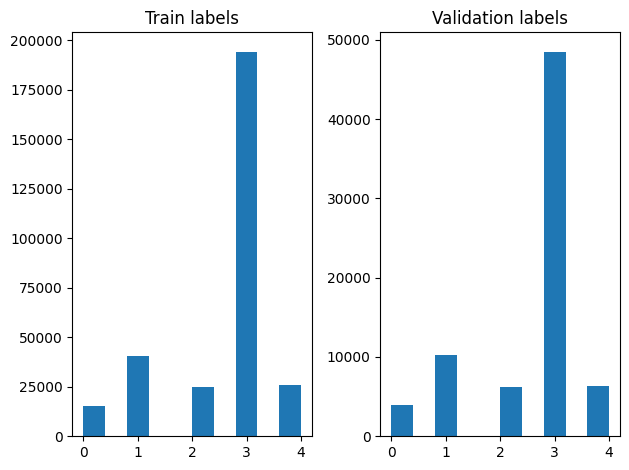

In [16]:
# plot training vs validation distribution
plt.subplot(1, 2, 1)
plt.hist(labels[0:train_size])
plt.title("Train labels")
plt.subplot(1, 2, 2)
plt.hist(labels[train_size:])
plt.title("Validation labels")
plt.tight_layout()

To create a [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) using a generator, we first write a generator function which reads each of the articles from `file_paths` and the labels from the label array, and yields one training example at each step. We pass this generator function to the [`tf.data.Dataset.from_generator`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator) method and specify the output types. Each training example is a tuple containing an article of `tf.string` data type and one-hot encoded label. We split the dataset with a train-validation split of 80-20 using [`tf.data.Dataset.skip`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#skip) and [`tf.data.Dataset.take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) methods.

In [17]:
def load_file(path, label):
    return tf.io.read_file(path), label

In [18]:
def make_datasets(train_size):
  batch_size = 256

  train_files = file_paths[:train_size]
  train_labels = labels[:train_size]
  train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
  train_ds = train_ds.map(load_file).shuffle(5000)
  train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  test_files = file_paths[train_size:]
  test_labels = labels[train_size:]
  test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
  test_ds = test_ds.map(load_file)
  test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


  return train_ds, test_ds

In [19]:
train_data, validation_data = make_datasets(train_size)

# Model Training and Evaluation

Since we have already added a wrapper around our module to use it as any other layer in Keras, we can create a small [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model which is a linear stack of layers. We can add our text embedding module with `model.add` just like any other layer. We compile the model by specifying the loss and optimizer and train it for 10 epochs. The `tf.keras` API can handle Tensorflow Datasets as input, so we can pass a Dataset instance to the fit method for model training. Since we are using the generator function, `tf.data` will handle generating the samples, batching them and feeding them to the model.

## Model

In [20]:
def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype=tf.string),
    embedding_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(5),
  ])
  model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer="adam", metrics=['accuracy'])
  return model

## Build the mechanized model

In [25]:
import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism

def create_model():
    model = MechanizedSequential(
        [
        tf.keras.layers.Input(shape=[], dtype=tf.string),
        embedding_layer,
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(5),
    ]
    )
    model.choose_mech(Mechanism.GAUSSIAN)
    model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer="adam", metrics=['accuracy'])
    model.summary()
    return model


In [26]:
model = create_model()
# Create earlystopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

Model: "mechanized_sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 300)               30000300  
                                                                 
 dense_3 (Dense)             (None, 64)                19264     
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 5)                 85        
                                                                 
Total params: 30,020,689
Trainable params: 20,389
Non-trainable params: 30,000,300
_________________________________________________________________


## Training

In [27]:

history = model.fit(train_data, 
                    validation_data=validation_data, 
                    epochs=5, 
                    callbacks=[early_stopping_callback])

Epoch 1/5
1176/1176 [==============================] - 47s 39ms/step - loss: 0.2269 - accuracy: 0.9238 - val_loss: 0.1505 - val_accuracy: 0.9468
Epoch 2/5
1176/1176 [==============================] - 44s 37ms/step - loss: 0.1397 - accuracy: 0.9507 - val_loss: 0.1354 - val_accuracy: 0.9513
Epoch 3/5
1176/1176 [==============================] - 46s 39ms/step - loss: 0.1282 - accuracy: 0.9535 - val_loss: 0.1275 - val_accuracy: 0.9541
Epoch 4/5
1176/1176 [==============================] - 45s 38ms/step - loss: 0.1215 - accuracy: 0.9556 - val_loss: 0.1218 - val_accuracy: 0.9557
Epoch 5/5
1176/1176 [==============================] - 45s 38ms/step - loss: 0.1165 - accuracy: 0.9572 - val_loss: 0.1182 - val_accuracy: 0.9566


## Evaluation

We can visualize the accuracy and loss curves for training and validation data using the `tf.keras.callbacks.History` object returned by the `tf.keras.Model.fit` method, which contains the loss and accuracy value for each epoch.

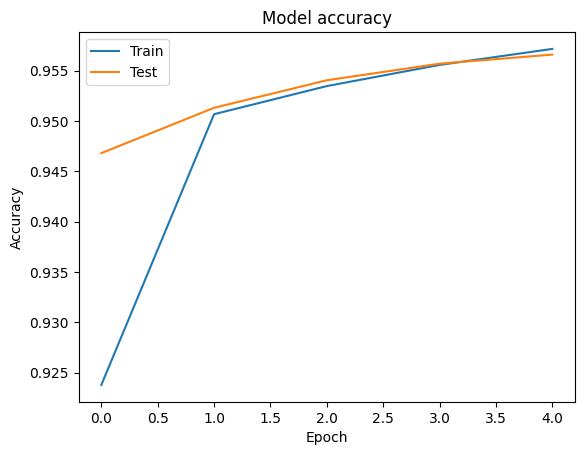

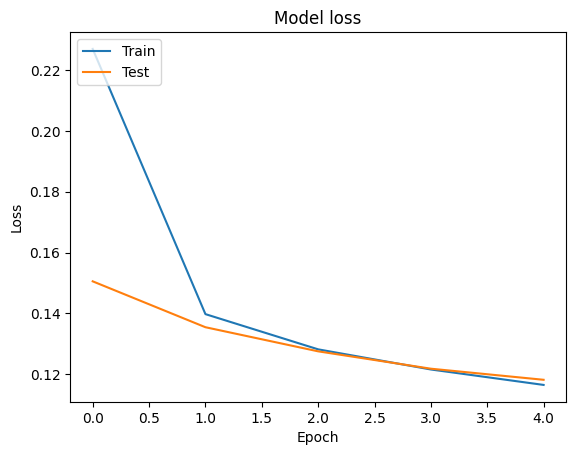

In [28]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Prediction

We can get the predictions for the validation data and check the confusion matrix to see the model's performance for each of the 5 classes. Because `tf.keras.Model.predict` method returns an n-d array for probabilities for each class, they can be converted to class labels using `np.argmax`.

In [29]:
y_pred = model.predict(validation_data)

294/294 [==============================] - 8s 26ms/step


In [30]:
y_pred = np.argmax(y_pred, axis=1)

In [31]:
samples = file_paths[0:3]
for i, sample in enumerate(samples):
  f = open(sample)
  text = f.read()
  print(text[0:100])
  print("True Class: ", sample.split("/")[0])
  print("Predicted Class: ", dir_names[y_pred[i]])
  f.close()
  


দক্ষিণ ভারতীয় বা কর্ণাটকি সংগীতের সম্রাট মঙ্গলামপালি বালমুরালিকৃষ্ণ (এম বালমুরালিকৃষ্ণ) গতকাল মঙ্গল
True Class:  entertainment
Predicted Class:  state

লন্ডনে সফররত বিএনপি চেয়ারপারসন খালেদা জিয়া দেশে ফিরবেন কি না, সেই সন্দেহ করে আলোচনা হয়েছে মন্ত্রিসভ
True Class:  state
Predicted Class:  state

আজ থেকে কুড়ি-পঁচিশ বছর পর আরিয়েন রোবেন নিশ্চয়ই চাইবেন না তাঁকে এভাবে স্মরণ করা হোক। যিনি কিনা তা
True Class:  sports
Predicted Class:  state


## Compare Performance

Now we can take the correct labels for the validation data from `labels` and compare them with our predictions to get a [classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html). 

In [32]:
y_true = np.array(labels[train_size:])

In [33]:
print(classification_report(y_true, y_pred, target_names=dir_names))

               precision    recall  f1-score   support

      economy       0.79      0.81      0.80      3897
       sports       0.99      0.98      0.98     10204
entertainment       0.91      0.94      0.93      6256
        state       0.97      0.97      0.97     48512
international       0.93      0.93      0.93      6377

     accuracy                           0.96     75246
    macro avg       0.92      0.93      0.92     75246
 weighted avg       0.96      0.96      0.96     75246



We can also compare our model's performance with the published results obtained in the original [paper](https://www.researchgate.net/publication/328214545_BARD_Bangla_Article_Classification_Using_a_New_Comprehensive_Dataset), which had a 0.96 precision .The original authors described many preprocessing steps performed on the dataset, such as dropping punctuations and digits, removing top 25 most frequest stop words. As we can see in the `classification_report`, we also manage to obtain a 0.96 precision and accuracy after training for only 5 epochs without any preprocessing! 

In this example, when we created the Keras layer from our embedding module, we set the parameter`trainable=False`, which means the embedding weights will not be updated during training. Try setting it to `True` to reach around 97% accuracy using this dataset after only 2 epochs. 